In [2]:
# Using tutorial for Gensim Topic Modeling
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

import re
import numpy as np
import pandas as pd

# Gensim helps with LDA Topic Modeling
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Lemmatization
import spacy

# Plotting
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt

# Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


C:\Users\11shr\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\11shr\Anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable
C:\Users\11shr\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in

In [3]:
# Data
data = pd.read_csv('SO_CI_Tag_Final.csv')
questions = data['Body'].tolist()

In [4]:
# Remove HTML tags
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [5]:
questions = [cleanhtml(q) for q in questions]
questions = [q.encode('ascii', 'ignore') for q in questions]
questions = [q.decode('ascii') for q in questions]


In [6]:
# Word decomposition
def words(list):
    for sentence in list:
        # deacc removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [7]:
data_words = list(words(questions))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [9]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [11]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [25]:


print(data_words_bigrams[:10])



[['new', 'test', 'cypress', 'gitlab', 'ci', 'idea', 'run', 'cypress', 'test', 'merge', 'know', 'change', 'url', 'testing', 'run', 'pipeline', 'gitlab', 'let_say', 'first', 'test', 'exibio', 'de', 'modal', 'clique', 'boto', 'cy_visit', 'http', 'cy', 'get', 'inner', 'header', 'pt', 'header', 'click', 'cy', 'get', 'modal', 'login', 'visible', 'local', 'environment', 'using', 'url', 'http', 'change', 'right', 'url', 'run', 'test', 'gitlab', 'ci', 'pipeline', 'help'], ['trying', 'make', 'ci', 'pipeline', 'run', 'phpunit', 'tests', 'via', 'github', 'actions', 'first', 'tests', 'work', 'fine', 'local', 'machine', 'mac_os', 'git', 'push', 'tests', 'pass', 'github', 'actions', 'server', 'ubuntu', 'got', 'modules', 'user', 'tests', 'feature', 'property', 'discounts', 'user_id', 'match', 'expected', 'value', 'failed', 'asserting', 'identical', 'see', 'actual', 'value', 'converted', 'string', 'idk', 'code', 'causes', 'error', 'code', 'assetion', 'actingas', 'user', 'get', 'route', 'profile', 'inde

In [13]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [14]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [15]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

In [16]:

# Create Corpus
texts = data_lemmatized

In [17]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [26]:
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 3), (21, 4), (22, 1), (23, 2), (24, 1), (25, 1)]]


In [27]:


id2word[0]



'change'

In [28]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('change', 1),
  ('ci', 1),
  ('click', 1),
  ('cypress', 2),
  ('environment', 1),
  ('first', 1),
  ('get', 2),
  ('header', 2),
  ('help', 1),
  ('idea', 1),
  ('inner', 1),
  ('know', 1),
  ('let_say', 1),
  ('local', 1),
  ('login', 1),
  ('merge', 1),
  ('modal', 2),
  ('new', 1),
  ('pipeline', 1),
  ('right', 1),
  ('run', 3),
  ('test', 4),
  ('testing', 1),
  ('url', 2),
  ('use', 1),
  ('visible', 1)]]

In [18]:
# Human readable format of corpus (term-frequency)
# print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.880520025398585


In [20]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.42696242403931367


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\11shr\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\Users\11shr\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\11shr\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.287068  0.058543       1        1  27.808494
0     -0.225151 -0.022725       2        1  17.691320
6     -0.220111  0.080767       3        1  16.974923
1     -0.111561 -0.106727       4        1  11.428568
7      0.117022 -0.129855       5        1   6.712593
5      0.159297  0.267094       6        1   6.439569
3      0.054311 -0.174790       7        1   5.349011
2      0.157251  0.253298       8        1   3.152398
9      0.174048 -0.116500       9        1   2.907050
8      0.181961 -0.109105      10        1   1.536073, topic_info=        Term          Freq         Total Category  logprob  loglift
132    build  31710.000000  31710.000000  Default  30.0000  30.0000
21      test  19466.000000  19466.000000  Default  29.0000  29.0000
179     file  12177.000000  12177.000000  Default  28.0000  28.0000
173  project  14833.000000  14833.000000  Default  27.0000  27.0000
20       run  15773.000000  15773.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
728     tool    304.545637   3749.161275  Topic10  -3.9146   1.6655
752    linux     80.042808    849.699606  Topic10  -5.2509   1.8136
256     root     74.920160   1134.006262  Topic10  -5.3170   1.4589
410      com     67.972639   2407.001240  Topic10  -5.4144   0.6089
479     task     67.386098   2866.839169  Topic10  -5.4230   0.4254

[494 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
363       1  0.128383   access
363       2  0.871071   access
511       4  0.993389  address
626       2  0.936360    agent
626       4  0.034037    agent
...     ...       ...      ...
162       4  0.479564    write
162       6  0.003811    write
336       6  0.919399      xml
336       7  0.079831      xml
1702      8  0.987824    xunit

[667 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 7, 2, 8, 6, 4, 3, 10, 9])

In [29]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=6):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(workers=4, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:


# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data, start=2, limit=50, step=6)




C:\Users\11shr\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
C:\Users\11shr\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
C:\Users\11shr\Anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


In [33]:
print(coherence_values)

[nan, nan, nan, nan, nan, nan, nan, nan]


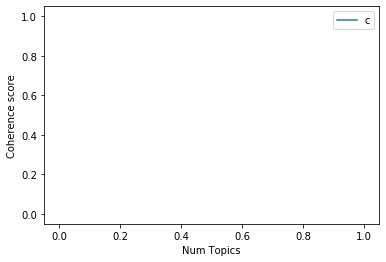

In [34]:
from matplotlib import pyplot as plt
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of nan
Num Topics = 8  has Coherence Value of nan
Num Topics = 14  has Coherence Value of nan
Num Topics = 20  has Coherence Value of nan
Num Topics = 26  has Coherence Value of nan
Num Topics = 32  has Coherence Value of nan
Num Topics = 38  has Coherence Value of nan
Num Topics = 44  has Coherence Value of nan
